# Remove bad disulfides, score with AF2

### Boilerplate

In [1]:
%load_ext lab_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders
dig66


### Make to remove disulfides that are bad, or in binders for APOE
Also need to reset numbering, and add sequence for chA to final scores

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.distributed import requires_init


@requires_init
def finalize_design(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
    """
    Remove disulfides that aren't needed and update scores
    """
    import bz2
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )
    from pyrosetta.rosetta.protocols.rosetta_scripts import XmlObjects

    if packed_pose_in == None:
        file = kwargs["-s"]
        with open(file, "rb") as f:
            packed_pose_in = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
        scores = dict(pyrosetta.distributed.cluster.get_scores_dict(file)["scores"])
    else:
        raise RuntimeError("Need to supply an input")

    if float(scores["dslf_fa13"]) > -0.9 or scores["target_name"] == "apoe":
        do_design = True
    else:
        do_design = False

    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" />
            <ScoreFunction name="sfxn_soft" weights="beta_nov16_soft" />
            <ScoreFunction name="sfxn_fa_atr" weights="empty" >
                <Reweight scoretype="fa_atr" weight="1" />
            </ScoreFunction>
            <ScoreFunction name="sfxn_relax" weights="beta_nov16" >
                <Reweight scoretype="arg_cation_pi" weight="3" />
                <Reweight scoretype="approximate_buried_unsat_penalty" weight="5" />
                <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-0.5" />
            </ScoreFunction>
            <ScoreFunction name="sfxn_design" weights="beta_nov16" >
                <Reweight scoretype="res_type_constraint" weight="1.5" />
                <Reweight scoretype="aa_composition" weight="1.0" />
                <Reweight scoretype="sap_constraint" weight="1.0" />
                <Reweight scoretype="netcharge" weight="1.0" />
                <Reweight scoretype="arg_cation_pi" weight="3" />
                <Reweight scoretype="approximate_buried_unsat_penalty" weight="5" />
                <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-0.5" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_cross_chain="-1" />
            </ScoreFunction>
            <ScoreFunction name="vdw_sol" weights="empty" >
                <Reweight scoretype="fa_atr" weight="1.0" />
                <Reweight scoretype="fa_rep" weight="0.55" />
                <Reweight scoretype="fa_sol" weight="1.0" />
            </ScoreFunction>
        </SCOREFXNS>
        <TASKOPERATIONS>
            <SelectBySASA name="PR_monomer_core_sel" mode="sc" state="monomer" probe_radius="2.2" core_asa="15" surface_asa="15" core="0" boundary="1" surface="1" verbose="0" />
        </TASKOPERATIONS>
        <RESIDUE_SELECTORS>
            <Chain name="chainA" chains="A"/>
            <Chain name="chainB" chains="B"/>
            <Neighborhood name="interface_chA" selector="chainB" distance="10.0" />
            <Neighborhood name="interface_chB" selector="chainA" distance="10.0" />
            <And name="AB_interface" selectors="interface_chA,interface_chB" />
            <Not name="Not_interface" selector="AB_interface" />
            <And name="actual_interface_chA" selectors="AB_interface,chainA" />
            <And name="actual_interface_chB" selectors="AB_interface,chainB" />
            <And name="chainB_not_interface" selectors="Not_interface,chainB" />
            <Not name="not_chB" selector="chainB" />
            <ResidueName name="pro_and_gly_positions" residue_name3="PRO,GLY" />
            <ResidueName name="just_CYS" residue_name3="CYS" />
            <ResidueName name="apolar" residue_name3="ALA,CYS,PHE,ILE,LEU,MET,THR,PRO,VAL,TRP,TYR" />
            <Not name="polar" selector="apolar" />
            <InterfaceByVector name="interface_by_vector" cb_dist_cut="11" nearby_atom_cut="5.5" vector_angle_cut="75" vector_dist_cut="9" grp1_selector="actual_interface_chA" grp2_selector="actual_interface_chB"/>
            <Task name="all_cores" fixed="true" task_operations="PR_monomer_core_sel" packable="false" designable="false"/>
            <And name="for_hydrophobic" selectors="actual_interface_chA,interface_by_vector">
                <Not selector="all_cores" />
            </And>            
            <Index name="patchdock_res" resnums="{interface_hydrophobics}" />
            <Index name="pocket" resnums="{interface_hydrophobics}" />
            <And name="target_not_pocket" selectors="chainB">
                <Not selector="pocket" />
            </And>
            <Layer name="surface" select_core="false" select_boundary="false" select_surface="true" use_sidechain_neighbors="true"/>
            <Layer name="boundary" select_core="false" select_boundary="true" select_surface="false" use_sidechain_neighbors="true"/>
            <Layer name="core" select_core="true" select_boundary="false" select_surface="false" use_sidechain_neighbors="true"/>
            <SecondaryStructure name="sheet" overlap="0" minH="3" minE="2" include_terminal_loops="false" use_dssp="true" ss="E"/>
            <SecondaryStructure name="entire_loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" use_dssp="true" ss="L"/>
            <SecondaryStructure name="entire_helix" overlap="0" minH="3" minE="2" include_terminal_loops="false" use_dssp="true" ss="H"/>
            <And name="helix_cap" selectors="entire_loop">
                <PrimarySequenceNeighborhood lower="1" upper="0" selector="entire_helix"/>
            </And>
            <And name="helix_start" selectors="entire_helix">
                <PrimarySequenceNeighborhood lower="0" upper="1" selector="helix_cap"/>
            </And>
            <And name="helix" selectors="entire_helix">
                <Not selector="helix_start"/>
            </And>
            <And name="loop" selectors="entire_loop">
                <Not selector="helix_cap"/>
            </And>
            <And name="surface_not_int" selectors="surface,chainA">
                <Not selector="AB_interface"/>
            </And>
            <And name="boundary_not_int" selectors="boundary,chainA">
                <Not selector="AB_interface"/>
            </And>
            <Or name="designable" selectors="just_CYS" />
            <Not name="not_designable" selector="designable" />
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <DesignRestrictions name="layer_design_F_boundary_M">
                <Action selector_logic="not_chB AND surface AND helix_start"  aas="DEHKPQR"/>
                <Action selector_logic="not_chB AND surface AND helix"        aas="EHKQR"/>
                <Action selector_logic="not_chB AND surface AND sheet"        aas="EHKNQRST"/>
                <Action selector_logic="not_chB AND surface AND loop"         aas="DEGHKNPQRST"/>
                <Action selector_logic="not_chB AND boundary AND helix_start" aas="ADEFHIKLMNPQRSTVWY"/>
                <Action selector_logic="not_chB AND boundary AND helix"       aas="ADEFHIKLMNQRSTVWY"/>
                <Action selector_logic="not_chB AND boundary AND sheet"       aas="DEFHIKLMNQRSTVWY"/>
                <Action selector_logic="not_chB AND boundary AND loop"        aas="ADEFGHIKLNPQRSTVWY"/>
                <Action selector_logic="not_chB AND core AND helix_start"     aas="AFILMPVWY"/>
                <Action selector_logic="not_chB AND core AND helix"           aas="AFILMVWYDENQSTH"/>
                <Action selector_logic="not_chB AND core AND sheet"           aas="FILMVWYDENQSTH"/>
                <Action selector_logic="not_chB AND core AND loop"            aas="AFGILPVWYDENQSTH"/>
                <Action selector_logic="not_chB AND helix_cap"                aas="DNST"/>
            </DesignRestrictions>
        </TASKOPERATIONS>
        <TASKOPERATIONS>
            <PruneBuriedUnsats name="prune_buried_unsats" allow_even_trades="false" atomic_depth_cutoff="3.5" minimum_hbond_energy="-0.5" />
            <IncludeCurrent name="current" />
            <LimitAromaChi2 name="limitchi2" chi2max="110" chi2min="70" include_trp="True" />
            <ExtraRotamersGeneric name="ex1_ex2" ex1="1" ex2aro="1" />
            <OperateOnResidueSubset name="designable_only" selector="not_designable">
                <RestrictToRepackingRLT/>
            </OperateOnResidueSubset>
            <DisallowIfNonnative name="disallow_GLY" resnum="0" disallow_aas="G" />
            <DisallowIfNonnative name="disallow_PRO" resnum="0" disallow_aas="P" />
            <OperateOnResidueSubset name="restrict_PRO_GLY" selector="pro_and_gly_positions">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
            <ProteinInterfaceDesign name="pack_long" design_chain1="0" design_chain2="0" jump="1" interface_distance_cutoff="15"/>
        </TASKOPERATIONS>
        <MOVERS>
            <DeleteRegionMover name="delete_target_not_pocket" residue_selector="target_not_pocket" rechain="false" />
            <SwitchChainOrder name="chain1onlypre" chain_order="1" />
            <ScoreMover name="scorepose" scorefxn="sfxn" verbose="false" />
            <ParsedProtocol name="chain1only">
                <Add mover="chain1onlypre" />
                <Add mover="scorepose" />
            </ParsedProtocol>
            <TaskAwareMinMover name="min" scorefxn="sfxn" bb="0" chi="1" task_operations="pack_long" />
            <DeleteRegionMover name="delete_polar" residue_selector="polar" rechain="false" />
        </MOVERS>
        <FILTERS>
            <Sasa name="interface_buried_sasa" confidence="0" />
            <Ddg name="ddg"  threshold="-10" jump="1" repeats="5" repack="1" relax_mover="min" confidence="0" scorefxn="sfxn" extreme_value_removal="1" />
            <ShapeComplementarity name="interface_sc" verbose="0" min_sc="0.55" write_int_area="1" write_median_dist="1" jump="1" confidence="0"/>
            <ShapeComplementarity name="interface_sc_for_fr1" verbose="0" min_sc="0.55" write_int_area="1" write_median_dist="1" jump="1" confidence="0"/>
            <ScoreType name="total_score_MBF" scorefxn="sfxn" score_type="total_score" threshold="0" confidence="0" />
            <MoveBeforeFilter name="total_score_monomer" mover="chain1only" filter="total_score_MBF" confidence="0" />
            <ResidueCount name="res_count_MBF" max_residue_count="9999" confidence="0"/>
            <MoveBeforeFilter name="res_count_monomer" mover="chain1only" filter="res_count_MBF" confidence="0" />
            <CalculatorFilter name="score_per_res" equation="total_score_monomer / res" threshold="-3.5" confidence="0">
                <Var name="total_score_monomer" filter="total_score_monomer"/>
                <Var name="res" filter="res_count_monomer"/>
            </CalculatorFilter>
            <BuriedUnsatHbonds name="buns_heavy_ball_1.1D" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" scorefxn="sfxn" residue_selector="AB_interface" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" use_ddG_style="true" burial_cutoff="0.01" dalphaball_sasa="true" probe_radius="1.1" max_hbond_energy="1.5" burial_cutoff_apo="0.2" />
            <BuriedUnsatHbonds name="sbuns5.0_heavy_ball_1.1D" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" scorefxn="sfxn" residue_selector="AB_interface" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" use_ddG_style="true" burial_cutoff="0.01" dalphaball_sasa="true" probe_radius="1.1" atomic_depth_selection="5.0" atomic_depth_deeper_than="false" burial_cutoff_apo="0.2" atomic_depth_resolution="0.49" max_hbond_energy="1.5"/>
            <BuriedUnsatHbonds name="vbuns5.0_heavy_ball_1.1D" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" scorefxn="sfxn" residue_selector="AB_interface" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" use_ddG_style="true" dalphaball_sasa="true" probe_radius="1.1" atomic_depth_selection="5.0" burial_cutoff="1000" burial_cutoff_apo="0.2" atomic_depth_apo_surface="5.5" atomic_depth_resolution="0.49" max_hbond_energy="1.5"/>
            <InterfaceHydrophobicResidueContacts name="hydrophobic_residue_contacts" target_selector="chainB" binder_selector="chainA" scorefxn="sfxn_soft" confidence="0"/> 
            <ContactMolecularSurface name="contact_molecular_surface" distance_weight="0.5" target_selector="chainA" binder_selector="chainB" confidence="0" />
            <ContactMolecularSurface name="contact_patch" distance_weight="0.5" target_selector="patchdock_res" binder_selector="chainA" confidence="0" />
            <Ddg name="ddg_hydrophobic_pre"  threshold="-10" jump="1" repeats="1" repack="0" confidence="0" scorefxn="vdw_sol" />
            <MoveBeforeFilter name="ddg_hydrophobic" mover="delete_polar" filter="ddg_hydrophobic_pre" confidence="0"/>
            <Ddg name="fa_atr_pocket_pre"  threshold="-15" jump="1" repeats="1" repack="0" confidence="0" scorefxn="sfxn_fa_atr" />
            <MoveBeforeFilter name="fa_atr_pocket" mover="delete_target_not_pocket" filter="fa_atr_pocket_pre" confidence="0"/>
            <SSShapeComplementarity name="ss_sc_pre" verbose="0" confidence="0" />
            <MoveBeforeFilter name="ss_sc" mover="chain1only" filter="ss_sc_pre" confidence="0"/>
            <Time name="timed"/>
        </FILTERS>
        <MOVERS>
            <FastDesign name="redesign_CYS" scorefxn="sfxn_design" repeats="1" task_operations="current,limitchi2,ex1_ex2,designable_only,disallow_GLY,disallow_PRO,restrict_PRO_GLY,prune_buried_unsats,layer_design_F_boundary_M" batch="false" ramp_down_constraints="false" cartesian="false" bondangle="false" bondlength="false" min_type="dfpmin_armijo_nonmonotone" relaxscript="InterfaceDesign2019" >
                <MoveMap name="MM" >
                        <Chain number="1" chi="true" bb="false" />
                        <Chain number="2" chi="true" bb="false" />
                        <Jump number="1" setting="false" />
                </MoveMap>
            </FastDesign>
        </MOVERS>
        <APPLY_TO_POSE>
        </APPLY_TO_POSE>
        <PROTOCOLS>
            <Add filter_name="interface_buried_sasa" />   
            <Add filter_name="ddg" />                     
            <Add filter="ddg_hydrophobic" />              
            <Add filter_name="interface_sc" />            
            <Add filter_name="score_per_res" />          
            <Add filter="vbuns5.0_heavy_ball_1.1D" />    
            <Add filter="sbuns5.0_heavy_ball_1.1D" />    
            <Add filter="buns_heavy_ball_1.1D" />    
            <Add filter="hydrophobic_residue_contacts" />
            <Add filter="fa_atr_pocket" />               
            <Add filter="contact_molecular_surface" />
            <Add filter="contact_patch" />   
            <Add filter="ss_sc" />   
        </PROTOCOLS>
        <OUTPUT />
    </ROSETTASCRIPTS>
    """.format(
        interface_hydrophobics=scores["interface_hydrophobics"],
    )
    cleaner = SingleoutputRosettaScriptsTask(xml)
    xml_obj = XmlObjects.create_from_string(xml)
    clean = xml_obj.get_mover("redesign_CYS")
    pose = packed_pose_in.pose.clone()
    if do_design:
        clean.apply(pose)
    else:
        pose.conformation().detect_disulfides()
    designed_ppose = cleaner(pose)
    new_scores = dict(designed_ppose.pose.scores)
    scores.update(new_scores)
    score_xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" />
        </SCOREFXNS>
        <MOVERS>
            <SwitchChainOrder name="chain1only" chain_order="1" />
            <RollMover name="move_chainA_far_away" chain="1" min_angle="0" max_angle="0" axis="x" >
                <translate x="1000" y="1000" z="1000" /> 
            </RollMover>
        </MOVERS>
        <RESIDUE_SELECTORS>
            <Chain name="chainA" chains="A"/>
            <Chain name="chainB" chains="B"/>
            <Neighborhood name="interface_chA" selector="chainB" distance="10.0" />
            <Neighborhood name="interface_chB" selector="chainA" distance="10.0" />
            <And name="AB_interface" selectors="interface_chA,interface_chB" />
            <Not name="Not_interface" selector="AB_interface" />
            <And name="actual_interface_chA" selectors="AB_interface,chainA" />
            <And name="actual_interface_chB" selectors="AB_interface,chainB" />
            <ResidueName name="apolar" residue_name3="ALA,CYS,PHE,ILE,LEU,MET,THR,PRO,VAL,TRP,TYR" />
            <And name="apolar_A" selectors="apolar,actual_interface_chA" />
            <And name="apolar_B" selectors="apolar,actual_interface_chB" />
            <Index name="patchdock_res" resnums="{interface_hydrophobics}" />
            <True name="true_sel" />
        </RESIDUE_SELECTORS>
        <SIMPLE_METRICS>
            <SapScoreMetric name="sap_score" score_selector="chainA" />
            <SapScoreMetric name="sap_score_target" score_selector="chainB" />
            <SapScoreMetric name="binder_blocked_sap" score_selector="chainA" sap_calculate_selector="chainA" sasa_selector="true_sel" />
            <SapScoreMetric name="target_blocked_sap" score_selector="chainB" sap_calculate_selector="chainB" sasa_selector="true_sel" />
        </SIMPLE_METRICS>
        <TASKOPERATIONS>
            <ProteinInterfaceDesign name="pack_long" design_chain1="0" design_chain2="0" jump="1" interface_distance_cutoff="15"/>
        </TASKOPERATIONS>
        <MOVERS>
            <TaskAwareMinMover name="min" scorefxn="sfxn" bb="0" chi="1" task_operations="pack_long" />
        </MOVERS>
        <FILTERS>
            <ContactMolecularSurface name="contact_patch" distance_weight="0.5" target_selector="patchdock_res" binder_selector="chainA" confidence="0" />
            <Ddg name="ddg"  threshold="-10" jump="1" repeats="5" repack="1" relax_mover="min" confidence="0" scorefxn="sfxn" extreme_value_removal="1" />
            <ResidueCount name="res_count_all" max_residue_count="9999" confidence="0"/>
            <BuriedSurfaceArea name="buried_npsa_FAMILYVW" select_only_FAMILYVW="True" atom_mode="hydrophobic_atoms" confidence="0.0" />
            <BuriedSurfaceArea name="buried_npsa" select_only_FAMILYVW="False" atom_mode="hydrophobic_atoms" confidence="0.0" />
            <ExposedHydrophobics name="exposed_hydrophobics"  confidence="0" />
            <CalculatorFilter name="buried_npsa_per_res" equation="total_score / res" threshold="-3.2" confidence="0">
                <Var name="total_score" filter="buried_npsa"/>
                <Var name="res" filter="res_count_all"/>
            </CalculatorFilter>
            <CalculatorFilter name="buried_npsa_FAMILYVW_per_res" equation="total_score / res" threshold="-3.2" confidence="0">
                <Var name="total_score" filter="buried_npsa_FAMILYVW"/>
                <Var name="res" filter="res_count_all"/>
            </CalculatorFilter>
            <MoveBeforeFilter name="buried_npsa_FAMILYVW_monomer" mover="chain1only" filter="buried_npsa_FAMILYVW" confidence="0" />
            <MoveBeforeFilter name="buried_npsa_monomer" mover="chain1only" filter="buried_npsa" confidence="0" />
            <MoveBeforeFilter name="exposed_hydrophobics_monomer" mover="chain1only" filter="exposed_hydrophobics" confidence="0" />
            <MoveBeforeFilter name="buried_npsa_per_res_monomer" mover="chain1only" filter="buried_npsa_per_res" confidence="0" />
            <MoveBeforeFilter name="buried_npsa_FAMILYVW_per_res_monomer" mover="chain1only" filter="buried_npsa_FAMILYVW_per_res" confidence="0" />
            <MoveBeforeFilter name="buried_npsa_FAMILYVW_apo" mover="move_chainA_far_away" filter="buried_npsa_FAMILYVW" confidence="0" />
            <MoveBeforeFilter name="buried_npsa_apo" mover="move_chainA_far_away" filter="buried_npsa" confidence="0" />
            <MoveBeforeFilter name="exposed_hydrophobics_apo" mover="move_chainA_far_away" filter="exposed_hydrophobics" confidence="0" />
            <CalculatorFilter   name="delta_buried_npsa_FAMILYVW" equation="complex - apo" threshold="-3.2" confidence="0">
                <Var name="complex" filter="buried_npsa_FAMILYVW"/>
                <Var name="apo"     filter="buried_npsa_FAMILYVW_apo"/>
            </CalculatorFilter>
            <CalculatorFilter   name="delta_buried_npsa" equation="complex - apo" threshold="-3.2" confidence="0">
                <Var name="complex" filter="buried_npsa"/>
                <Var name="apo"     filter="buried_npsa_apo"/>
            </CalculatorFilter>
            <CalculatorFilter   name="delta_exposed_hydrophobics" equation="complex - apo" threshold="-3.2" confidence="0">
                <Var name="complex" filter="exposed_hydrophobics"/>
                <Var name="apo"     filter="exposed_hydrophobics_apo"/>
            </CalculatorFilter>
            <ContactMolecularSurface name="contact_molecular_surface_ap_target" distance_weight="0.5" target_selector="apolar_B" binder_selector="chainA" confidence="0" />
            <ContactMolecularSurface name="contact_molec_sq5_ap_target" distance_weight="0.5" target_selector="apolar_B" binder_selector="chainA" confidence="0" near_squared_size="5" />
            <ContactMolecularSurface name="contact_molecular_surface_apap_target" distance_weight="0.5" target_selector="apolar_B" binder_selector="chainA" confidence="0" apolar_target="true" />
            <ContactMolecularSurface name="contact_molec_sq5_apap_target" distance_weight="0.5" target_selector="apolar_B" binder_selector="chainA" confidence="0" near_squared_size="5" apolar_target="true" />
            <ContactMolecularSurface name="contact_molecular_surface_ap_binder" distance_weight="0.5" target_selector="apolar_A" binder_selector="chainB" confidence="0" />
            <ContactMolecularSurface name="contact_molec_sq5_ap_binder" distance_weight="0.5" target_selector="apolar_A" binder_selector="chainB" confidence="0" near_squared_size="5" />
            <ContactMolecularSurface name="contact_molecular_surface_apap_binder" distance_weight="0.5" target_selector="apolar_A" binder_selector="chainB" confidence="0" apolar_target="true" />
            <ContactMolecularSurface name="contact_molec_sq5_apap_binder" distance_weight="0.5" target_selector="apolar_A" binder_selector="chainB" confidence="0" near_squared_size="5" apolar_target="true" />
            <worst9mer name="pre_wnm_all" rmsd_lookup_threshold="0.4" confidence="0" />
            <worst9mer name="pre_wnm_hlx" rmsd_lookup_threshold="0.4" confidence="0" only_helices="true" />
            <MoveBeforeFilter name="wnm_all" mover="chain1only" filter="pre_wnm_all" confidence="0" />
            <MoveBeforeFilter name="wnm_hlx" mover="chain1only" filter="pre_wnm_hlx" confidence="0" />
        </FILTERS>
        <PROTOCOLS>
            <Add filter="contact_molecular_surface_ap_target" />
            <Add filter="contact_molec_sq5_ap_target" />
            <Add filter="contact_molecular_surface_apap_target" />
            <Add filter="contact_molec_sq5_apap_target" />
            <Add filter="contact_patch"/>
            <Add filter="ddg"/>
            <Add filter="wnm_all"/>
            <Add filter="wnm_hlx"/>
            <Add metrics="sap_score" />
            <Add metrics="sap_score_target" />
            <Add metrics="binder_blocked_sap" />
            <Add metrics="target_blocked_sap" />
        </PROTOCOLS>
        <OUTPUT />
    </ROSETTASCRIPTS>
    """.format(
        interface_hydrophobics=scores["interface_hydrophobics"],
    )
    scorer = SingleoutputRosettaScriptsTask(score_xml)
    scored_ppose = scorer(designed_ppose.pose.clone())
    final_scores = dict(scored_ppose.pose.scores)
    scores.update(final_scores)
    scored_pose = io.to_pose(scored_ppose)
    pyrosetta.rosetta.core.pose.clearPoseExtraScores(scored_pose)
    scores["chA_length"] = scored_pose.chain_end(1)
    scores["chA_seq"] = scored_pose.chain_sequence(1)
    keys = [
        "bb_clash",
        "binder_blocked_sap",
        "buns_heavy_ball_1.1D",
        "cart_bonded",
        "chA_length",
        "chA_seq",
        "closure_type",
        "contact_molec_sq5_ap_target",
        "contact_molec_sq5_apap_target",
        "contact_molecular_surface",
        "contact_molecular_surface_ap_target",
        "contact_molecular_surface_apap_target",
        "contact_patch",
        "ddg",
        "ddg_hydrophobic",
        "disulfide_at",
        "docked_helix",
        "dslf_fa13",
        "fa_atr",
        "fa_atr_pocket",
        "fa_dun_dev",
        "fa_dun_rot",
        "fa_dun_semi",
        "fa_elec",
        "fa_intra_atr_xover4",
        "fa_intra_elec",
        "fa_intra_rep_xover4",
        "fa_intra_sol_xover4",
        "fa_rep",
        "fa_sol",
        "hbond_bb_sc",
        "hbond_lr_bb",
        "hbond_sc",
        "hbond_sr_bb",
        "hxl_tors",
        "hydrophobic_residue_contacts",
        "interface_buried_sasa",
        "interface_hydrophobic_count",
        "interface_hydrophobics",
        "interface_polar_count",
        "lk_ball",
        "lk_ball_bridge",
        "lk_ball_bridge_uncpl",
        "lk_ball_iso",
        "new_loop_resis",
        "omega",
        "p_aa_pp",
        "parent",
        "parent_length",
        "pivot_helix",
        "pre_break_helix",
        "prefix",
        "pro_close",
        "rama_prepro",
        "ref",
        "rmsd",
        "sap_score",
        "sap_score_target",
        "sbuns5.0_heavy_ball_1.1D",
        "score_per_res",
        "shift",
        "ss_sc",
        "suffix",
        "target_blocked_sap",
        "target_length",
        "target_name",
        "target_seq",
        "threaded_seq",
        "total_length",
        "vbuns5.0_heavy_ball_1.1D",
        "wnm_all",
        "wnm_hlx",
    ]
    for key, value in scores.items():
        if key in keys:
            pyrosetta.rosetta.core.pose.setPoseExtraScore(scored_pose, key, str(value))
        else:
            pass
    final_ppose = io.to_packed(scored_pose)
    return final_ppose

### Setup dask, set command line options, make tasks and submit to client again to cleanup disulfides

In [3]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from glob import glob
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)


def create_tasks(to_clean):
    with open(to_clean, "r") as f:
        for file in f:
            tasks = {"options": "-corrections::beta_nov16 true"}
            tasks["extra_options"] = options
            tasks["-s"] = file.rstrip()
            yield tasks


logging.basicConfig(level=logging.INFO)


options = {
    "-out:level": "300",
    "-precompute_ig": "true",
    "-detect_disulf": "false",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
}

run the following from your local terminal:
ssh -L 8000:localhost:8787 pleung@dig166


### Cleanup disulfides
Do short designs first

In [4]:
to_clean = os.path.join(os.getcwd(), "03_filter/cleanup_short.list")
output_path = os.path.join(os.getcwd(), "04_cleanup_short")

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="6GB",
        queue="medium",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-510 workers,
        cluster.adapt(
            minimum=1,
            maximum=510,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=create_tasks(to_clean),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
            ).distribute(protocols=[finalize_design])

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=6G
#SBATCH -t 23:30:00

JOB_ID=${SLURM_JOB_ID%;*}

/home/pleung/.conda/envs/phil/bin/python -m distributed.cli.dask_worker tcp://172.16.131.50:41143 --nthreads 1 --memory-limit 5.59GiB --name name --nanny --death-timeout 120 --local-directory $TMPDIR/dask --lifetime 23h --lifetime-stagger 4m

<Client: 'tcp://172.16.131.50:41143' processes=0 threads=0, memory=0 B>


INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.27+release.7ce64884a77d606b7b667c363527acc846541030 2021-07-09T18:10:05] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


### Cleanup disulfides
Now do long designs

In [5]:
options["-out:level"] = "100"
to_clean = os.path.join(os.getcwd(), "03_filter/cleanup_long.list")
output_path = os.path.join(os.getcwd(), "04_cleanup_long")

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="6GB",
        queue="medium",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-510 workers,
        cluster.adapt(
            minimum=1,
            maximum=510,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=create_tasks(to_clean),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
            ).distribute(protocols=[finalize_design])

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=6G
#SBATCH -t 23:30:00

JOB_ID=${SLURM_JOB_ID%;*}

/home/pleung/.conda/envs/phil/bin/python -m distributed.cli.dask_worker tcp://172.16.131.50:33447 --nthreads 1 --memory-limit 5.59GiB --name name --nanny --death-timeout 120 --local-directory $TMPDIR/dask --lifetime 23h --lifetime-stagger 4m

<Client: 'tcp://172.16.131.50:33447' processes=0 threads=0, memory=0 B>


### Look at scores
Hacky function to load JSON-like data

In [12]:
def read_scorefile(scores):
    import pandas as pd
    from tqdm import tqdm

    dfs = []
    with open(scores, "r") as f:
        for line in tqdm(f):
            dfs.append(pd.read_json(line).T)
    tabulated_scores = pd.concat(dfs)
    return tabulated_scores

### Get short first

In [16]:
%%time
output_path = os.path.join(os.getcwd(), "04_cleanup_short")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.to_json(os.path.join(output_path, "scores.json"))

1it [00:10, 10.86s/it]


CPU times: user 12.6 s, sys: 1.51 s, total: 14.1 s
Wall time: 14.8 s


### Reload as JSON

In [17]:
scores_df = pd.read_json(os.path.join(os.getcwd(), "04_cleanup_short", "scores.json"))

### Plotting functions and config

In [19]:
sns.set(
    context="talk",
    font_scale=1.5,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)


def rho(x, y, ax=None, **kwargs):
    """Plot the correlation coefficient in the top left hand corner of a plot.
    https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot-using-seaborn-in-python/50835066
    """
    import scipy

    r, _ = scipy.stats.pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1"
    ax.annotate(f"{rho} = {r:.2f}", xy=(0.1, 0.9), xycoords=ax.transAxes)


def plot_unity(xdata, ydata, **kwargs):
    """https://stackoverflow.com/questions/48122019/how-can-i-plot-identity-lines-on-a-seaborn-pairplot"""
    xmin, ymin = (xdata.min(), ydata.min())
    xmax, ymax = (xdata.max(), ydata.max())
    xpoints = np.linspace(xmin, xmax, 100)
    ypoints = np.linspace(ymin, ymax, 100)
    plt.gca().plot(
        xpoints, ypoints, color="k", marker=None, linestyle="--", linewidth=4.0
    )

In [20]:
scores_df.columns

Index(['bb_clash', 'binder_blocked_sap', 'buns_heavy_ball_1.1D', 'chA_length',
       'chA_seq', 'closure_type', 'contact_molec_sq5_ap_target',
       'contact_molec_sq5_apap_target', 'contact_molecular_surface',
       'contact_molecular_surface_ap_target',
       'contact_molecular_surface_apap_target', 'contact_patch', 'ddg',
       'ddg_hydrophobic', 'disulfide_at', 'docked_helix', 'dslf_fa13',
       'fa_atr', 'fa_atr_pocket', 'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi',
       'fa_elec', 'fa_intra_atr_xover4', 'fa_intra_elec',
       'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep', 'fa_sol',
       'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'hxl_tors',
       'hydrophobic_residue_contacts', 'interface_buried_sasa',
       'interface_hydrophobic_count', 'interface_hydrophobics',
       'interface_polar_count', 'lk_ball', 'lk_ball_bridge',
       'lk_ball_bridge_uncpl', 'lk_ball_iso', 'new_loop_resis', 'omega',
       'p_aa_pp', 'parent', 'parent_length', 'pivot_

### Plot length distribution

{156, 162, 155, 148}


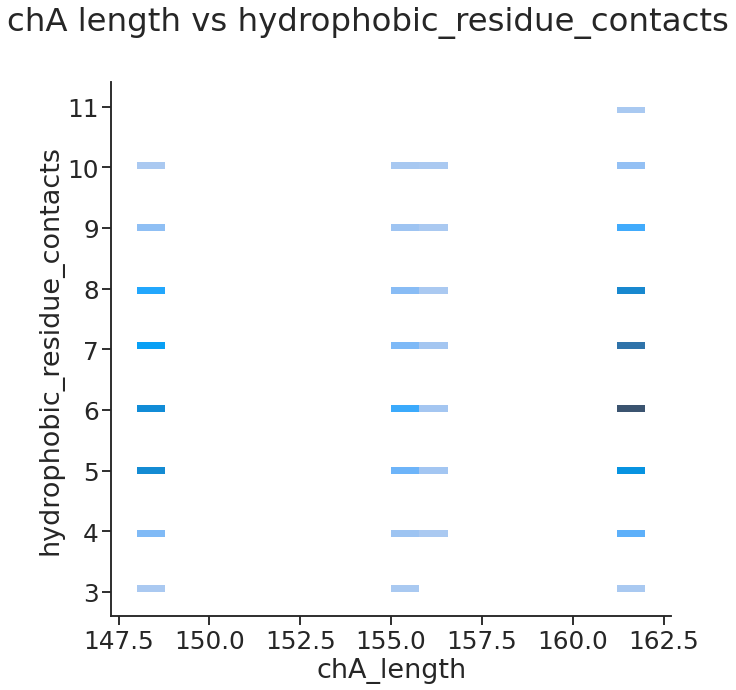

In [21]:
print(set(scores_df["chA_length"]))

fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
sns.histplot(ax=ax, x="chA_length", y="hydrophobic_residue_contacts", data=scores_df)
plt.suptitle(f"chA length vs hydrophobic_residue_contacts")
sns.despine()
plt.savefig(f"figs/04_length_vs_hydrophobic_residue_contacts.png")

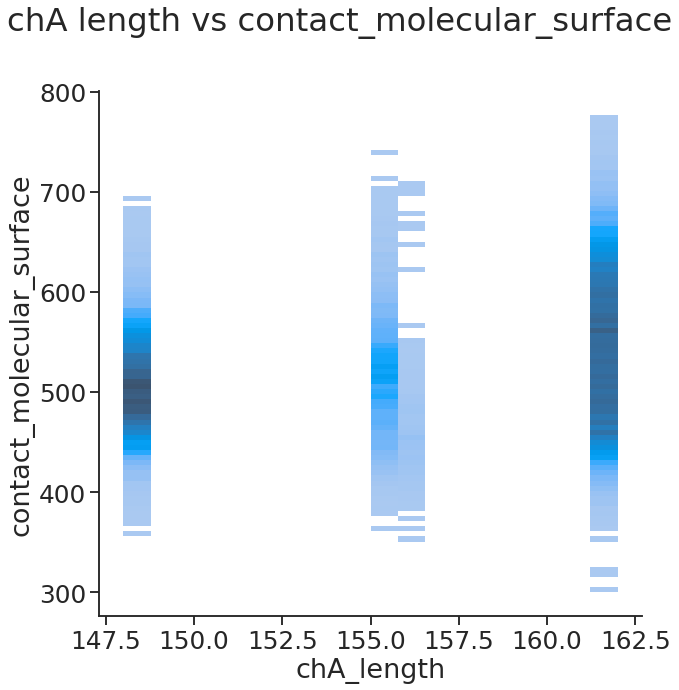

In [22]:
fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
sns.histplot(ax=ax, x="chA_length", y="contact_molecular_surface", data=scores_df)
plt.suptitle(f"chA length vs contact_molecular_surface")
sns.despine()
plt.savefig(f"figs/04_length_vs_contact_molecular_surface.png")

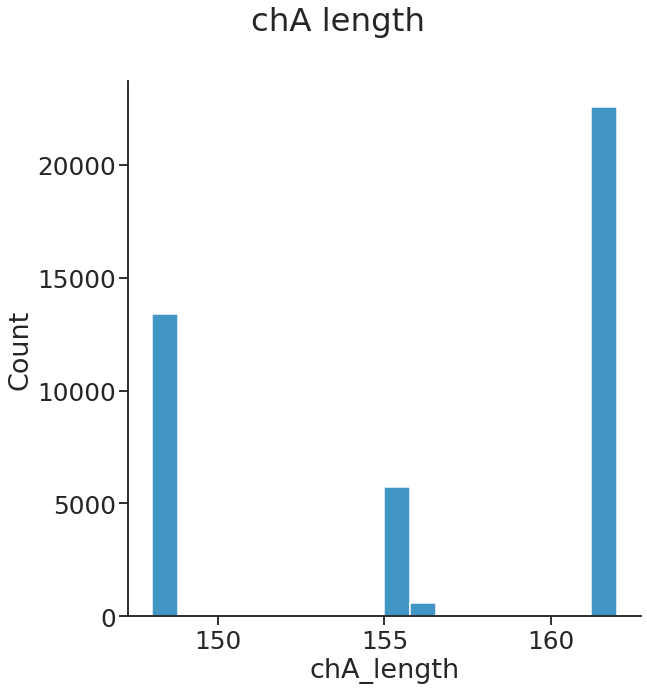

In [23]:
fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
sns.histplot(ax=ax, x="chA_length", data=scores_df)
plt.suptitle(f"chA length")
sns.despine()
plt.savefig(f"figs/04_chA_length.png")

### Get the best short designs for filtering with AF2

In [24]:
df_filt = scores_df[scores_df["rmsd"] < 0.5]
df_filt = df_filt[df_filt["vbuns5.0_heavy_ball_1.1D"] < 2]
df_filt = df_filt[df_filt["ddg"] < -40]
print(len(scores_df))
print(len(df_filt))

42312
39965


In [9]:
with open(os.path.join(os.getcwd(), "04_cleanup_short", "af2_sample.list"), "w+") as f:
    for line in df_filt.index:
        print(line, file=f)

### We're gonna use backfill to run all AF2 models on the short designs
Will submit everything to `short'
Make `SLURM` array tasks

In [2]:
import os, stat, subprocess


def create_tasks(selected):
    with open(selected, "r") as f:
        for file in f:
            tasks = {}
            path = file.rstrip()
            tasks["-s"] = path
            yield tasks


def file_len(file):
    """https://stackoverflow.com/questions/845058/how-to-get-line-count-of-a-large-file-cheaply-in-python"""
    with open(file) as f:
        for i, l in enumerate(f):
            pass
    return i + 1


# cleanup old cmdslists
for cmdslist in glob(os.path.join(os.getcwd(), "04*.cmds")):
    os.remove(cmdslist)

targets = os.path.join(os.getcwd(), "04_cleanup_short/af2_sample.list")
detail = os.path.join(os.getcwd(), "run_af2.py")

jid = "{SLURM_JOB_ID%;*}"
sid = "{SLURM_ARRAY_TASK_ID}p"

for i, tasks in enumerate(tqdm(create_tasks(targets))):
    j = int(i / 20000)
    k = int(i / 1000)
    tasklist = f"04_run_af2_short_{j}.cmds"
    gpu = ""
    queue = "short"
    core_mem = "#SBATCH --mem=4G \n"
    run_sh = """#!/usr/bin/env bash \n#SBATCH -J inference \n#SBATCH -e /mnt/home/pleung/logs/slurm_logs/detail-%J.err \n#SBATCH -o /mnt/home/pleung/logs/slurm_logs/detail-%J.out \n#SBATCH -p {queue} \n{gpu}{core_mem}\nJOB_ID=${jid} \nCMD=$(sed -n "${sid}" {tasklist}) \necho "${c}" | bash""".format(
        queue=queue,
        gpu=gpu,
        core_mem=core_mem,
        jid=jid,
        sid=sid,
        tasklist=tasklist,
        c="{CMD}",
    )
    shell = f"04_run_af2_short_{j}.sh"
    with open(shell, "w+") as f:
        print(run_sh, file=f)
    st = os.stat(shell)
    os.chmod(shell, st.st_mode | stat.S_IEXEC)
    with open(tasklist, "a+") as f:
        outpath = os.path.join(os.getcwd(), f"04_run_af2_short_{j}")
        full_outpath = os.path.join(os.getcwd(), outpath, f"{k}".zfill(4))
        args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
        cmd = f"mkdir -p {full_outpath}; cd {full_outpath}; {detail} {args_}"
        print(cmd, file=f)

# Let's go
print("Run the following commands")
for i in range(2):
    print(
        f"sbatch -a 1-$(cat 04_run_af2_short_{i}.cmds | wc -l) 04_run_af2_short_{i}.sh"
    )

39965it [00:36, 1098.78it/s]


Run the following commands
sbatch -a 1-$(cat 04_run_af2_short_0.cmds | wc -l) 04_run_af2_short_0.sh
sbatch -a 1-$(cat 04_run_af2_short_1.cmds | wc -l) 04_run_af2_short_1.sh


### Now need to retrieve the JSONs containing scores for the AF2 short runs

In [90]:
!mv 04*.sh 04_cleanup_short; mv 04*.cmds 04_cleanup_short

mv: cannot stat '04*.sh': No such file or directory
mv: cannot stat '04*.cmds': No such file or directory


In [3]:
%%time
import json, time


output_paths = glob(os.path.join(os.getcwd(), f"04_cleanup_short/decoys/*/*.json"))
print(f"reading {len(output_paths)} runs")
time.sleep(0.5)
scores = {} 
for path in tqdm(output_paths):
    pdb = path.replace("json", "pdb.bz2")
    key = f"{pdb}"
    with open(path, "r") as f:
        try:
            values_dict = json.load(f)
            values = {}
            for model, results in values_dict.items():

                values["plddt_"+model] = values_dict[model]["average_plddts"]
                values["rmsd_"+model] = values_dict[model]["rmsd_to_input"]
            del values_dict
        except:
            print(path)
    scores[key] = values
scores_df = pd.DataFrame(scores)
scores_df = scores_df.T
output_path = os.path.join(os.getcwd(), "04_run_af2_short")
os.makedirs(output_path, exist_ok=True)
output_file = os.path.join(output_path, f"af2_scores.json")
scores_df.to_json(output_file)

reading 39912 runs


100%|██████████| 39912/39912 [44:44<00:00, 14.86it/s] 


CPU times: user 34min 41s, sys: 2min 54s, total: 37min 35s
Wall time: 44min 46s


In [33]:
output_path = os.path.join(os.getcwd(), "04_run_af2_short")
scores_df = pd.read_json(os.path.join(output_path, "af2_scores.json"))

### Cleanup old jsons

In [ ]:
!rm -r 04_run_af2_short_*; for f in 04_cleanup_short/decoys/*/*.json; do rm $f; done

### Analyze AF2 results for short seqs

In [34]:
scores_df.head()

,plddt_model_4,rmsd_model_4,plddt_model_3,rmsd_model_3,plddt_model_5,rmsd_model_5,plddt_model_1,rmsd_model_1,plddt_model_2,rmsd_model_2
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/04_cleanup_short/decoys/0000/2021.08.04.09.17.34.501637_45aba596d47d479981dce199d8ddb14a.pdb.bz2,85.921111,2.725136,91.312248,1.108352,81.864823,6.999903,84.695091,2.287854,87.204097,2.885724
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/04_cleanup_short/decoys/0000/2021.08.04.09.17.34.501637_1b395519b8194e0a899e7f605cf6184c.pdb.bz2,93.182848,4.219015,94.460508,4.166640,94.669931,4.121743,93.670435,4.266333,93.425857,4.279224
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/04_cleanup_short/decoys/0000/2021.08.04.09.17.34.501637_7c8309d2295e4208b9eedd9eb7202421.pdb.bz2,91.305591,2.863236,89.046280,2.959882,87.142282,2.131945,88.219241,2.154126,88.261850,2.236032
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/04_cleanup_short/decoys/0000/2021.08.04.09.17.34.501637_4e9be2af3c674d988ea535135782f40e.pdb.bz2,96.196656,0.818115,96.074745,0.946108,96.541085,0.852232,95.305782,0.872729,94.982869,0.915151
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/04_cleanup_short/decoys/0000/2021.08.04.09.17.34.501637_d8fcaadb2ff443eda204e24c6eff9965.pdb.bz2,93.494511,3.546651,93.235444,3.572066,94.097860,3.591488,92.994685,3.604729,93.859427,3.636713


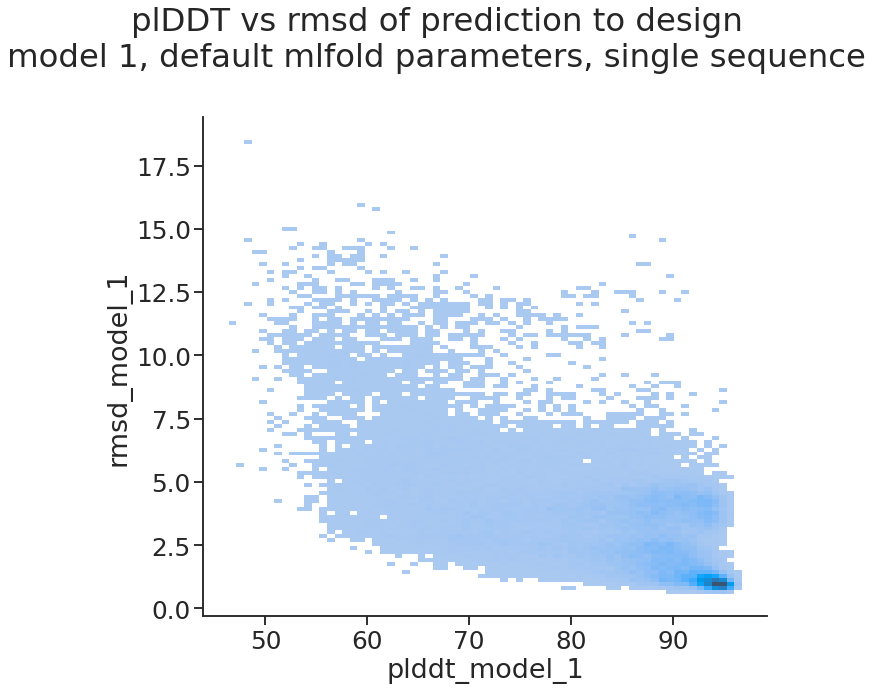

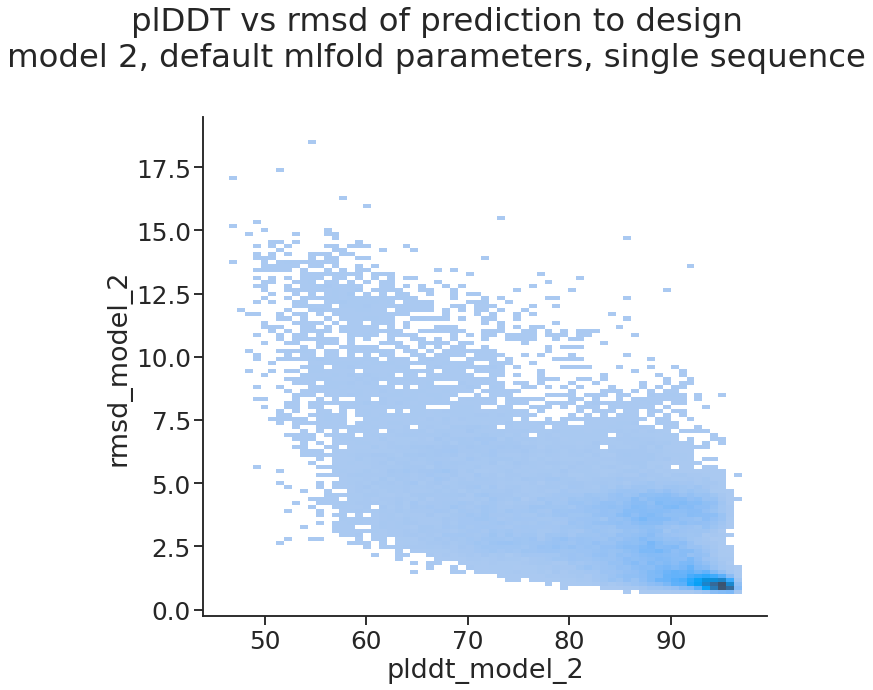

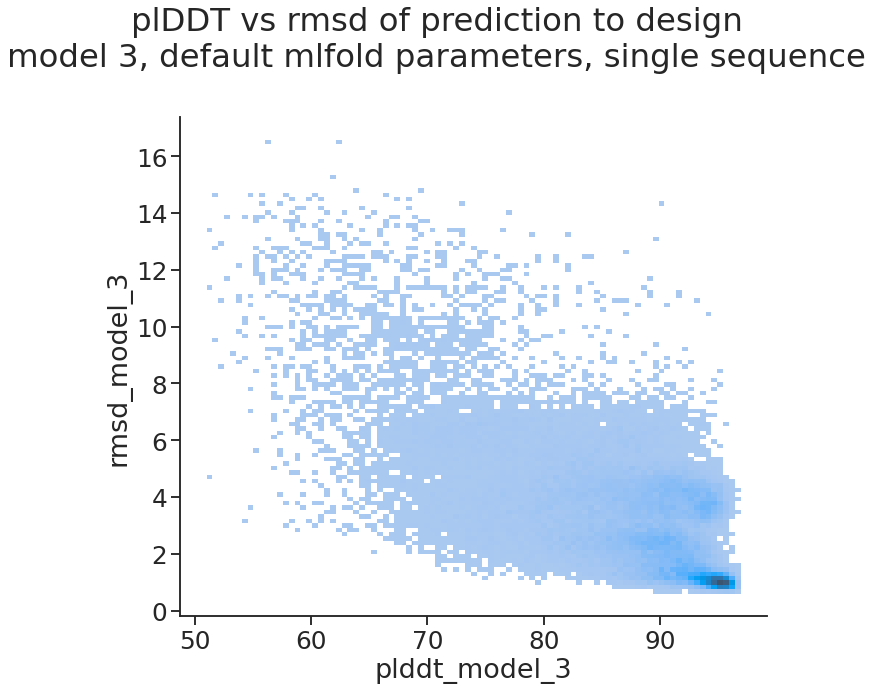

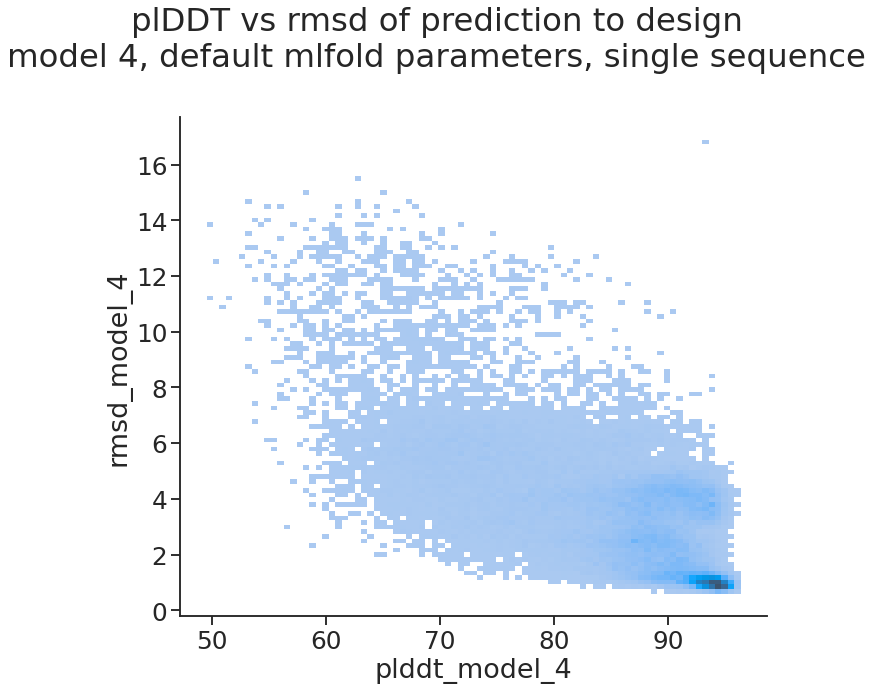

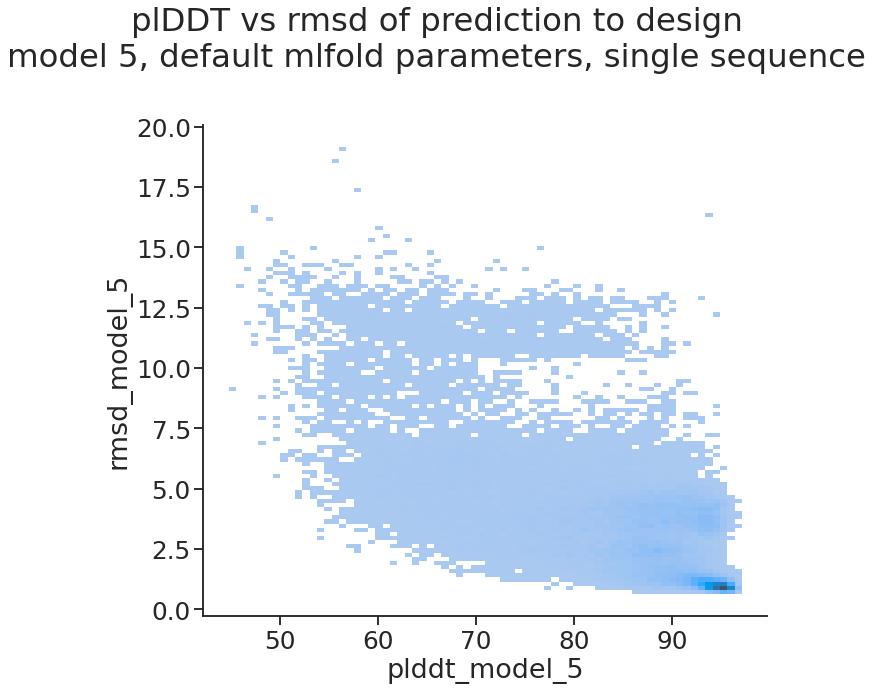

In [9]:
scores_df = scores_df.apply(pd.to_numeric, errors="coerce")

for model in "1 2 3 4 5".split():
    fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
    sns.histplot(
        ax=ax, x=f"plddt_model_{model}", y=f"rmsd_model_{model}", data=scores_df
    )
    plt.suptitle(
        f"plDDT vs rmsd of prediction to design\nmodel {model}, default mlfold parameters, single sequence"
    )
    sns.despine()
    plt.savefig(f"figs/04_plDDT_vs_rmsd_model_{model}.png")

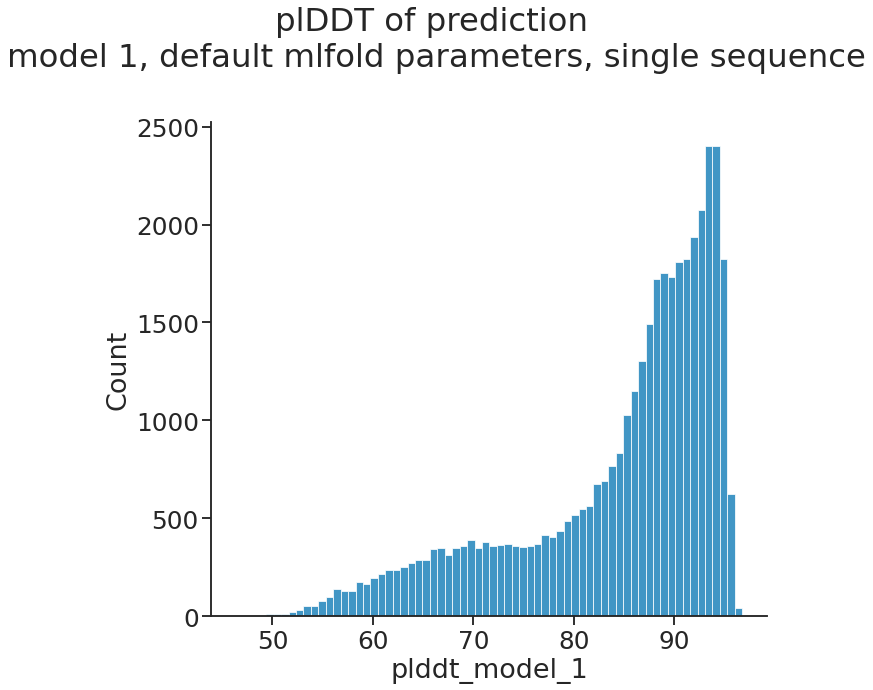

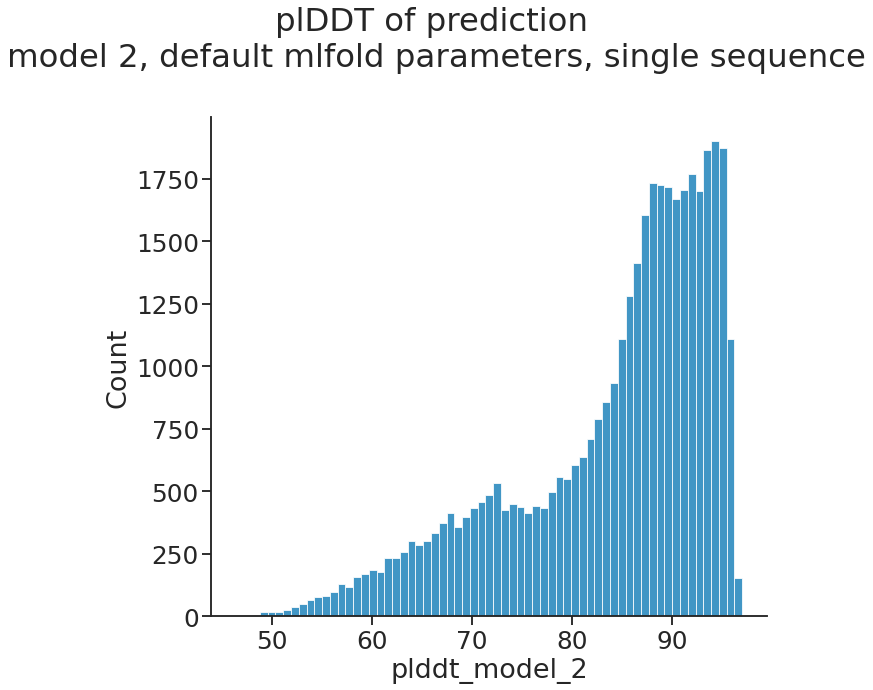

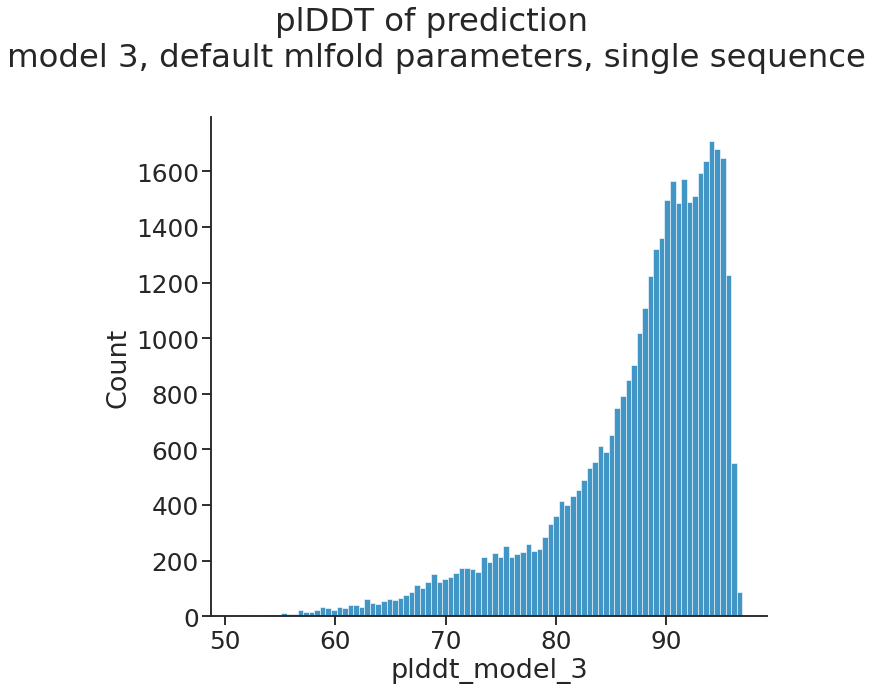

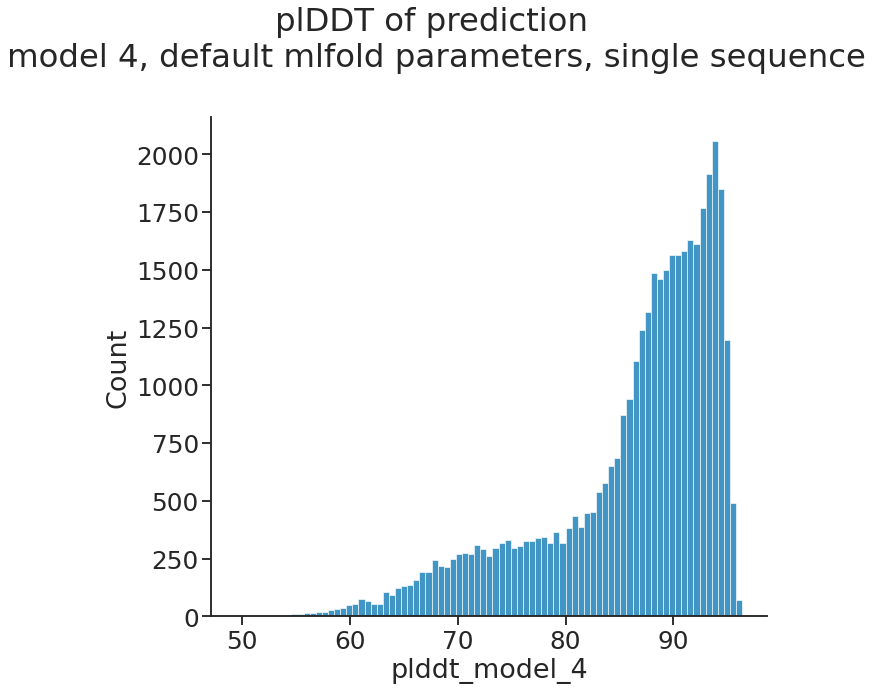

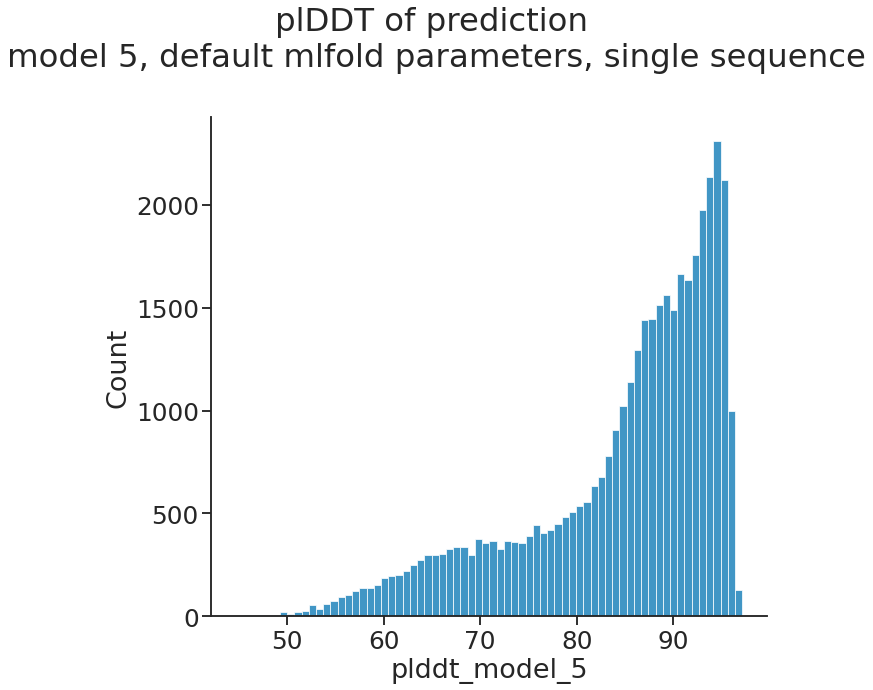

In [10]:
for model in "1 2 3 4 5".split():
    fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
    sns.histplot(ax=ax, x=f"plddt_model_{model}", data=scores_df)
    plt.suptitle(
        f"plDDT of prediction \nmodel {model}, default mlfold parameters, single sequence"
    )
    sns.despine()
    plt.savefig(f"figs/04_plDDT_model_{model}.png")

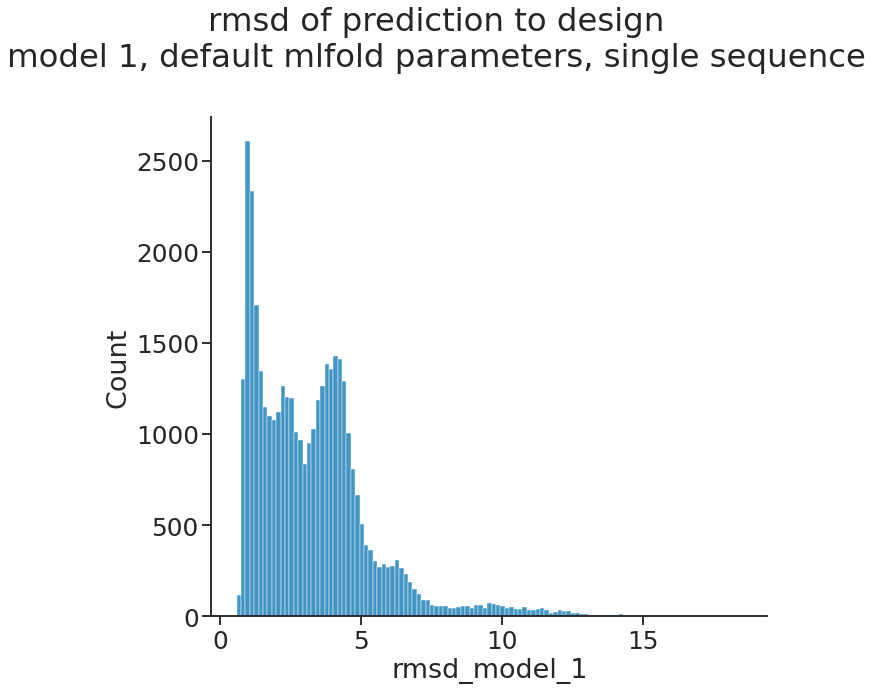

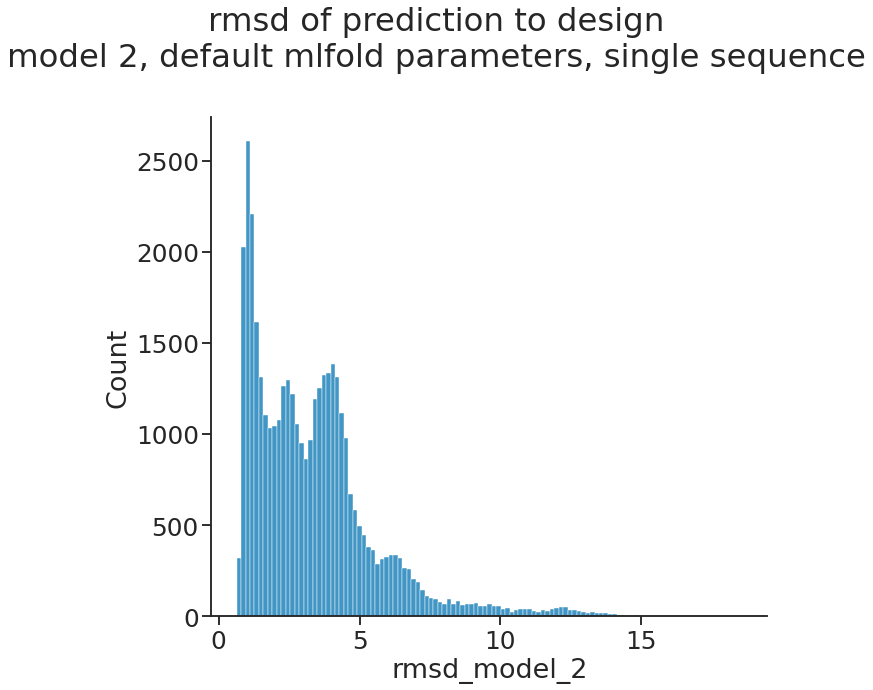

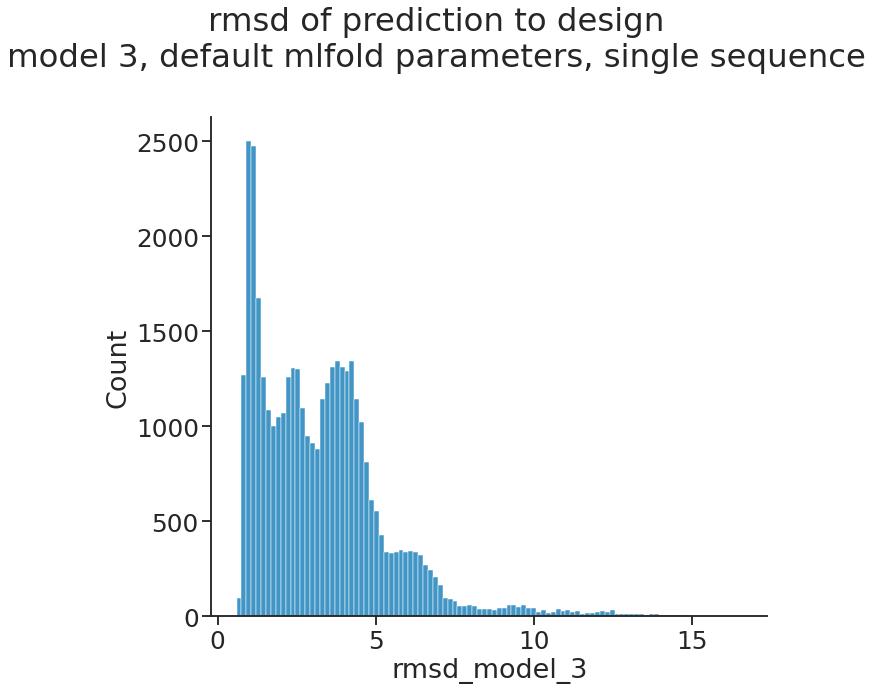

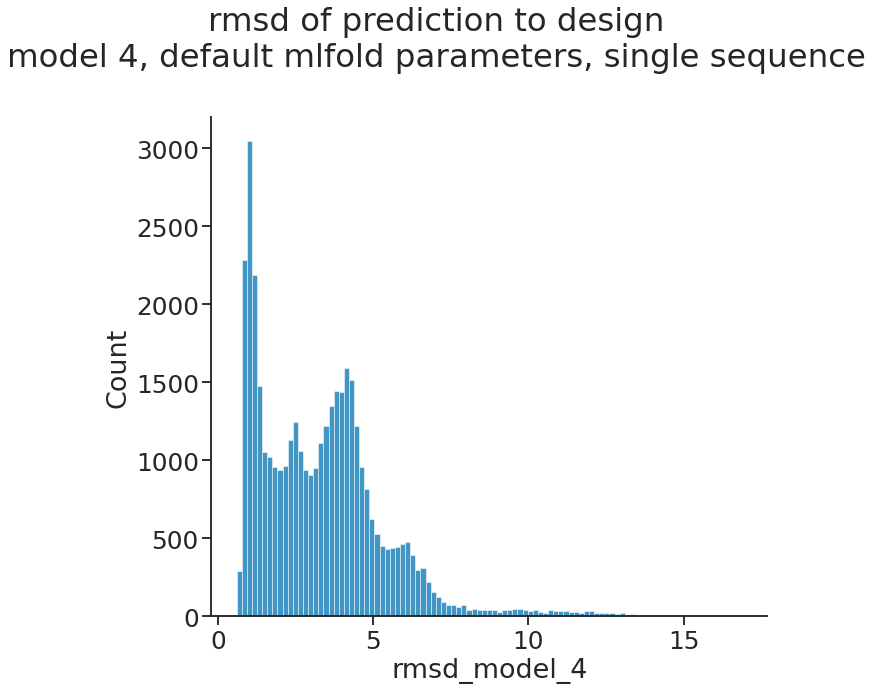

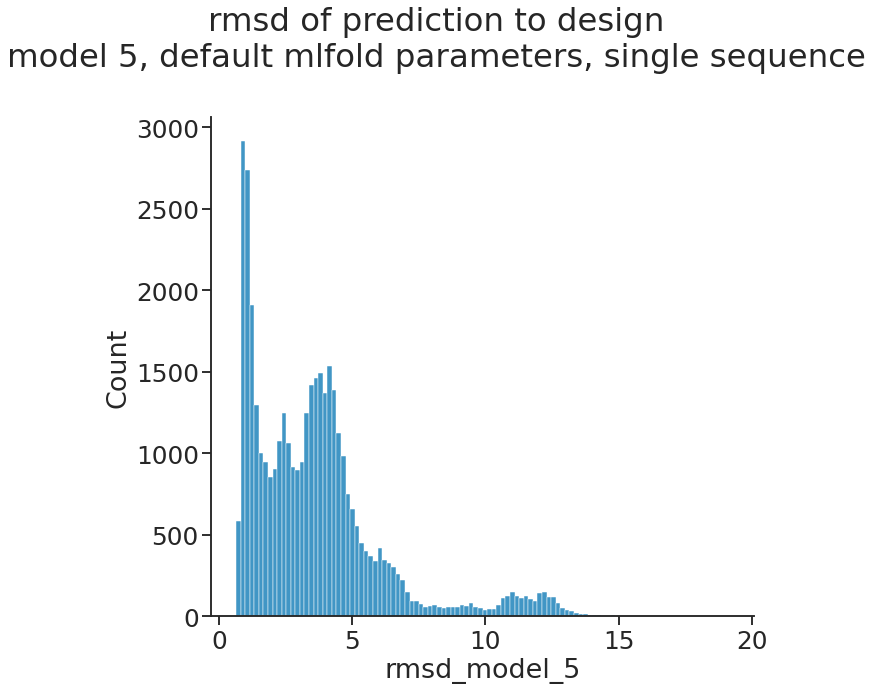

In [11]:
for model in "1 2 3 4 5".split():
    fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
    sns.histplot(ax=ax, x=f"rmsd_model_{model}", data=scores_df)
    plt.suptitle(
        f"rmsd of prediction to design\nmodel {model}, default mlfold parameters, single sequence"
    )
    sns.despine()
    plt.savefig(f"figs/04_rmsd_model_{model}.png")

### Now time to combine AF2 results with original `scores_df`

In [36]:
full_df = pd.concat([df_filt, scores_df], axis=1)
output_path = os.path.join(os.getcwd(), "04_run_af2_short")
output_file = os.path.join(output_path, f"all_scores.json")
scores_df.to_json(output_file)

In [37]:
print(set(full_df.parent.values))

{'KH_R4_PXX13', 'DHR21', 'DHR52_nocys', 'DHR39', 'TH_DHR_2_NSR', 'DHR07_nocys', 'hDHR54_5CWL', 'hDHR14_5H7C', 'hDHR49_5CWJ', 'hDHR14_5CWH', 'DHR54', 'DHR53', 'DHR01_nocys'}


In [39]:
best_short = full_df.query(
    "(rmsd_model_1 <= 2 | rmsd_model_2 <= 2 | rmsd_model_3 <= 2 | rmsd_model_4 <= 2 | rmsd_model_5 <= 2) & (plddt_model_1 >= 80 | plddt_model_2 >= 80 |plddt_model_3 >= 80 |plddt_model_4 >= 80 | plddt_model_5 >= 80)"
)

# best_short = results_df[results_df["rmsd"] <= 2]
# best_short = best_short[best_short["lDDT"] >= 85]
# excellent = excellent[excellent["d_SAP_complex_formation"] < -25]
# excellent = excellent[excellent["d_tot_complex_formation"] < -50]
# excellent = excellent[excellent["cms_Y"] > 600]

# print(len(set(best_short.state.values)))
print(len(best_short))
print(len(set(best_short.parent.values)))
best_short.groupby("target_name").count()

17618
13


,bb_clash,binder_blocked_sap,buns_heavy_ball_1.1D,chA_length,chA_seq,closure_type,contact_molec_sq5_ap_target,contact_molec_sq5_apap_target,contact_molecular_surface,contact_molecular_surface_ap_target,...,plddt_model_4,rmsd_model_4,plddt_model_3,rmsd_model_3,plddt_model_5,rmsd_model_5,plddt_model_1,rmsd_model_1,plddt_model_2,rmsd_model_2
target_name,,,,,,,,,,,,,,,,,,,,,
apoe,520,520,520,520,520,520,520,520,520,520,...,520,520,520,520,520,520,520,520,520,520
covstem,196,196,196,196,196,196,196,196,196,196,...,196,196,196,196,196,196,196,196,196,196
gip,2361,2361,2361,2361,2361,2361,2361,2361,2361,2361,...,2361,2361,2361,2361,2361,2361,2361,2361,2361,2361
glp,4027,4027,4027,4027,4027,4027,4027,4027,4027,4027,...,4027,4027,4027,4027,4027,4027,4027,4027,4027,4027
glucagon,2113,2113,2113,2113,2113,2113,2113,2113,2113,2113,...,2113,2113,2113,2113,2113,2113,2113,2113,2113,2113
neuropeptideY,4669,4669,4669,4669,4669,4669,4669,4669,4669,4669,...,4669,4669,4669,4669,4669,4669,4669,4669,4669,4669
pth,3732,3732,3732,3732,3732,3732,3732,3732,3732,3732,...,3732,3732,3732,3732,3732,3732,3732,3732,3732,3732


### Drop duplicate seqs

17618


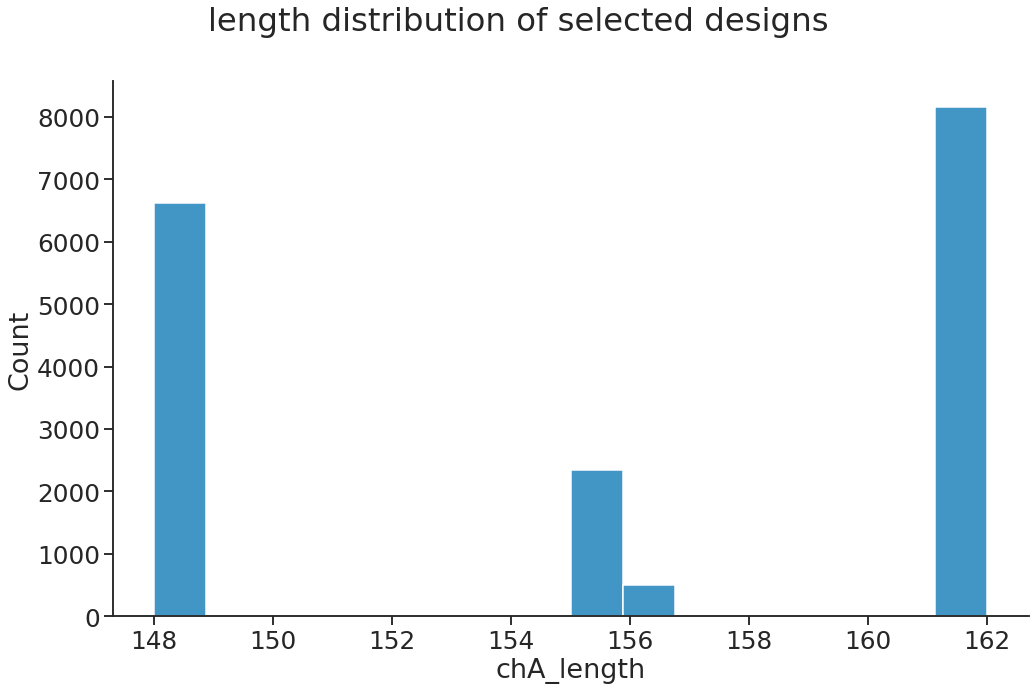

In [86]:
no_dup = best_short.drop_duplicates(subset="chA_seq")
print(len(no_dup))

no_dup.sort_values(by="chA_length", ascending=True)
fig, ax = plt.subplots(figsize=(15, 10), tight_layout=True)
sns.histplot(ax=ax, x="chA_length", data=no_dup)
plt.suptitle(f"length distribution of selected designs")
sns.despine()
plt.savefig(f"figs/04_chA_lengths.png")

In [87]:
output_path = os.path.join(os.getcwd(), "04_run_af2_short")
output_file = os.path.join(output_path, f"to_order.json")
no_dup.to_json(output_file)

### Unused blocks

In [ ]:
%%time
import pyrosetta
from pyrosetta.distributed import cluster
import pyrosetta.distributed.io as io

flags = """
-out:level 300
-precompute_ig true
-detect_disulf false
-corrections::beta_nov16 true
-holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc
-indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5
"""
# pyrosetta.distributed.init(" ".join(flags.replace("\n\t", " ").split()))
pyrosetta.init(" ".join(flags.replace("\n\t", " ").split()))

t = finalize_design(
    None,
    **{
        "-s": "/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/03_detail_0/0081/47f6c6fcb6d1e9c788e002cfeb798d0bfbc3f514e73931c8.pdb.bz2",
#         "-s": "/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/03_detail_0/0018/8aeb40fd33d90cbae3429aac01b14b7f45a054268e56fea7.pdb.bz2",
    }
)